In [3]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
from scipy import stats
from tqdm import tqdm

from utils import Wishart, runge_kutta, lorentz_ode

from sklearn.cluster import DBSCAN

## Generating Lorentz Time Series

Before trying our model on financila data, we want to test it on simplier data. As financial time series are basically chaotic time series with a noise component. We first test our model on chaotic time series - Lorentz time series. Then, we test our model on Lorentz time series with added noise. And only after that, if it works well, we move to real life financial data.

In [8]:
time_steps = np.linspace(0, 1200, 12001)
params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
xyz0 = np.array([1., 1., 1.])

lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)

lorenz_solution = lorenz_solution[1000:]
xs, ys, zs = lorenz_solution.T

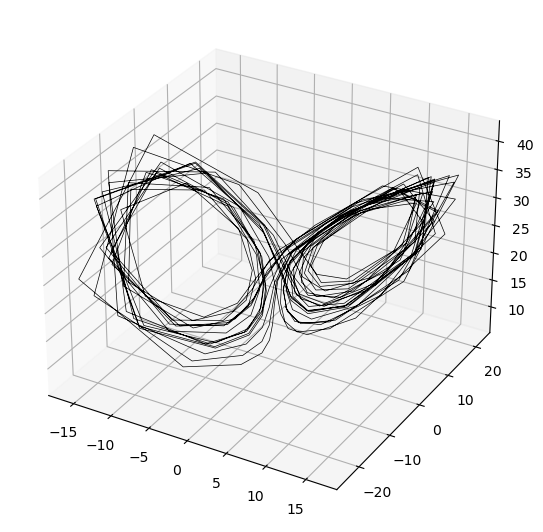

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6.66, 6.66), subplot_kw={"projection": "3d"})
ax.plot(xs[1000:1300], ys[1000:1300], zs[1000:1300], lw=0.5, c='black')
plt.show()

In [10]:
xs = (xs - min(xs)) / (max(xs) - min(xs))
ys = (ys - min(ys)) / (max(ys) - min(ys))
zs = (zs - min(zs)) / (max(zs) - min(zs))

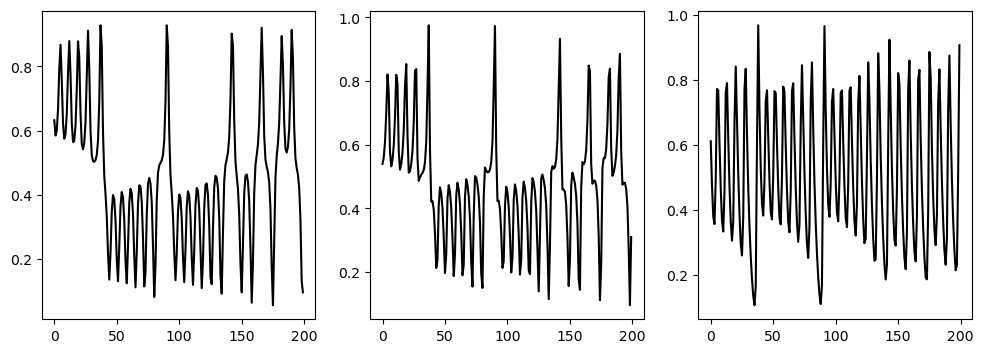

In [11]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].plot(xs[-200:], c='black')
axs[1].plot(ys[-200:], c='black')
axs[2].plot(zs[-200:], c='black')
plt.show()

## Predictive Clustering

As it was stated above, we need to predict financial time series - chaotic time series with noise. To predict chaotic time series you should consider specially designed methods. Such as predictive clustering. Below we implement this algorithm and test on Lorentz data.

#### Generating patterns

In [14]:
def generate_patterns(K, L):   
    patterns = np.array(list(itertools.product(np.arange(1, K+1), repeat=L-1)))
    return patterns

In [15]:
patterns = generate_patterns(10, 4)
print(patterns[[0, 613, 999]])

[[ 1  1  1]
 [ 7  2  4]
 [10 10 10]]


#### Obtaining motives

In [16]:
def get_samples(x, pattern):
    T = len(x)
    inds = np.array([0, *np.cumsum(pattern)])

    samples = []
    for i in range(T-inds[-1]):
        samples.append(x[inds+i])
        
    return np.array(samples)


def get_motives(x, patterns, clusters=False):
    
    if not clusters:
        motives = [get_samples(x, pattern) for pattern in patterns]
        return motives
    
    motives = []
    
    for pattern in patterns:
        samples = generate_samples(x, pattern)
        
        lorenz_WC = Wishart(11, 0.2)
        _ = lorenz_WC.fit(samples)
        
        cluster_centers = []
        
        # zero cluster is noise
        for l in range(len(lorenz_WC.clusters_to_objects)):
            cluster_l = samples[lorenz_WC.clusters_to_objects[l]]

            if l == 0 or len(cluster_l) == 0:
                continue
            
            cluster_centers.append(list(np.mean(cluster_l, axis=0)))
        
        motives.append(np.array(cluster_centers))
        
    return motives

In [17]:
x_train, x_test = xs[:10000], xs[10000:]

In [18]:
motives = get_motives(x_train, patterns)

#### Prediction

In [19]:
def get_set_of_predictions(X, motives, patterns, f_dist, eps=0.005):
    set_predictions = []
    distances = []
    
    for i in range(len(patterns)):
        pattern = -np.cumsum(patterns[i][::-1])[::-1]
        new_motive = X[pattern]

        distances_i = f_dist(new_motive, motives[i][:, :-1])
        good_inds = distances_i < eps
        
        distances.extend(distances_i[good_inds])
        set_predictions.extend(motives[i][:,-1][good_inds])
        
    
    return np.array(set_predictions), np.array(distances)

def f_dist(x, y):
    return np.linalg.norm(x-y, axis=1)

In [20]:
set_of_predictions, distances = get_set_of_predictions(x_train, motives, patterns, f_dist, 0.01)

(0.0, 1.0)

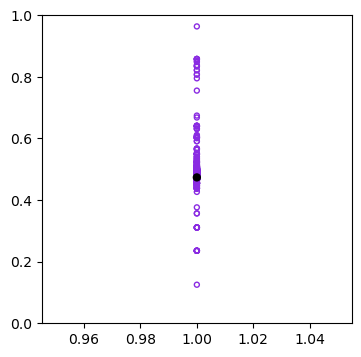

In [21]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(np.ones(len(set_of_predictions)), set_of_predictions, fc='none', ec='blueviolet', s=13)
ax.scatter(1, x_test[0], fc='black', ec='none')
plt.ylim(0,1)

In [22]:
def get_single_prediction(set_predictions, distances, method):
    if method == 'mode':
        return stats.mode(set_predictions, keepdims=True)[0]
    
    if method == 'mean':
        return np.mean(set_predictions)
    
    if method == 'wmean':
        weights = distances / np.sum(distances)
        return np.mean(weights*set_predictions)
    
    if method == 'dbscan':
        
        eps, min_samples = 0.01, 5
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        dbs.fit(set_predictions.reshape(-1, 1))
        
        cluster_labels, cluster_sizes = np.unique(dbs.labels_[dbs.labels_ > -1], return_counts=True)
        
        if cluster_labels.size > 0:
            prediction = set_predictions[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction

#### Single step ahead prediction

In [23]:
x_train, x_test = xs[:10000], xs[10000:]

In [24]:
dbscan_predictions_1step = []
mode_predicitons_1step = []
wmean_predicitons_1step = []

for i in tqdm(range(100)):
    set_of_predictions, distances = get_set_of_predictions(x_train, motives, patterns, f_dist, 0.01)
    
    x_train = np.append(x_train, x_test[i])
    
    dbscan_predictions_1step.append(get_single_prediction(set_of_predictions, distances, method='dbscan'))
    mode_predicitons_1step.append(get_single_prediction(set_of_predictions, distances, method='mode'))
    wmean_predicitons_1step.append(get_single_prediction(set_of_predictions, distances, method='wmean'))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


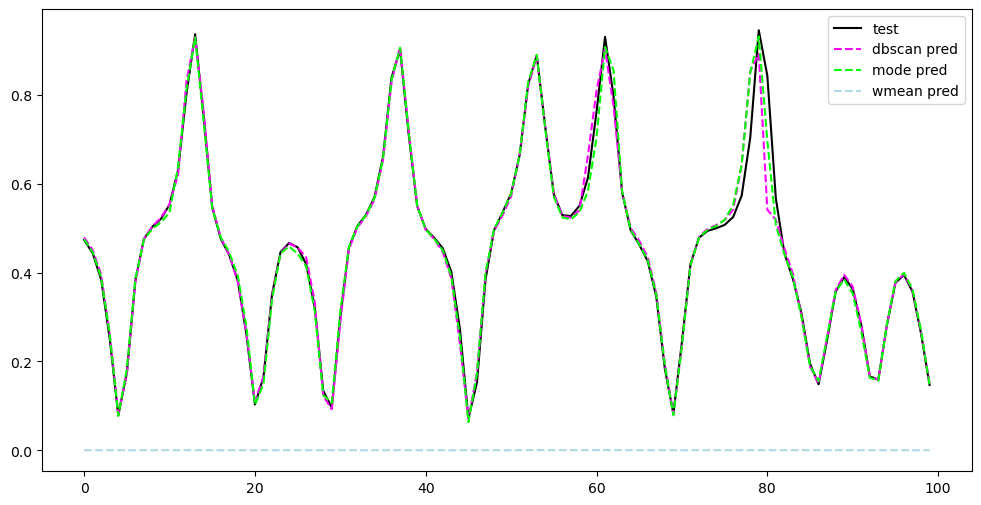

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(x_test[:100], c='black', label='test')
ax.plot(dbscan_predictions_1step, c='magenta', label='dbscan pred', ls='--')
ax.plot(mode_predicitons_1step, c='lime', label='mode pred', ls='--')
ax.plot(wmean_predicitons_1step, c='lightblue', label='wmean pred', ls='--')

plt.legend()
plt.show()

#### Mutiple step ahead prediction

In [26]:
x_train, x_test = xs[:10000], xs[10000:]

In [27]:
dbscan_predictions = []
for i in tqdm(range(100)):
    set_of_predictions, distances = get_set_of_predictions(x_train, motives, patterns, f_dist, 0.01)
    
    prediction = get_single_prediction(set_of_predictions, distances, method='dbscan')
    
    dbscan_predictions.append(prediction)
    
    x_train = np.append(x_train, prediction)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


In [28]:
x_train, x_test = xs[:10000], xs[10000:]

In [29]:
mode_predictions = []
for i in tqdm(range(100)):
    set_of_predictions, distances = get_set_of_predictions(x_train, motives, patterns, f_dist, 0.01)
    
    prediction = get_single_prediction(set_of_predictions, distances, method='mode')
    
    mode_predictions.append(prediction)
    
    x_train = np.append(x_train, prediction)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


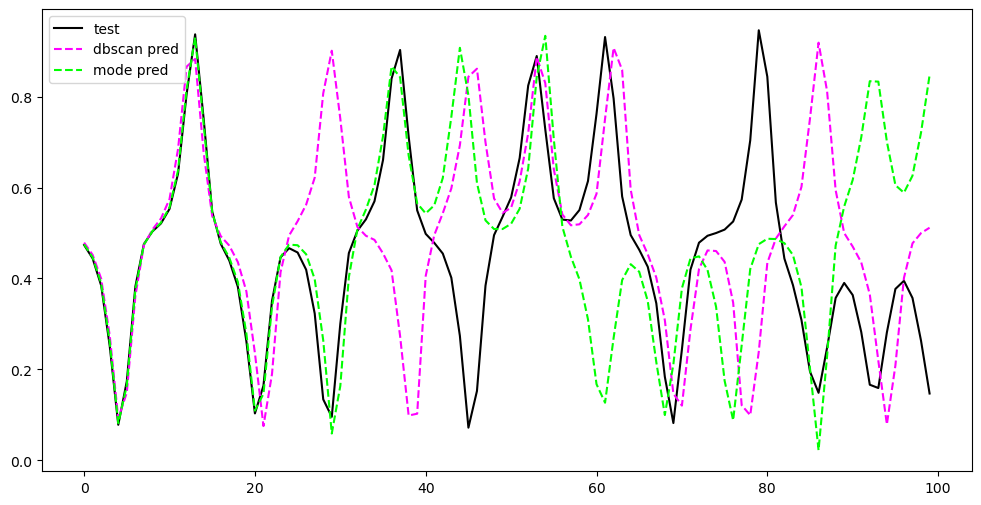

In [30]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(x_test[:100], c='black', label='test')
ax.plot(dbscan_predictions, c='magenta', label='dbscan pred', ls='--')
ax.plot(mode_predictions, c='lime', label='mode pred', ls='--')
plt.legend()
plt.show()

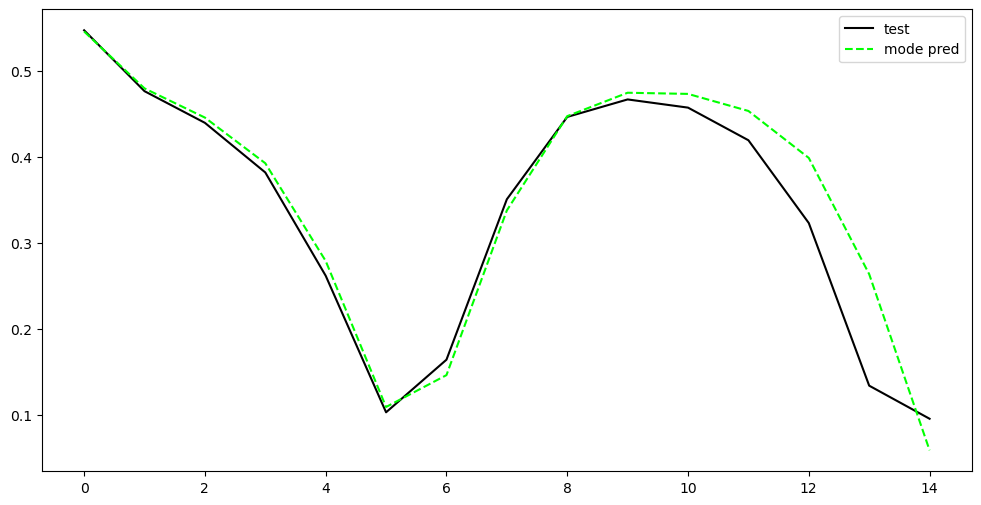

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(x_test[15:30], c='black', label='test')
ax.plot(mode_predictions[15:30], c='lime', label='mode pred', ls='--')
plt.legend()
plt.show()

#### Adding non-predictable points

There is a modification of the standard algorithm which allows to skip some points when forecasting in order to avoid exponential growth of error. This is basically the main trick which allows to predict chaotic time series for multiple steps ahead. Below we implement this modification.

In [32]:
def get_single_prediction(set_predictions, distances, method):
    if len(set_predictions) == 0:
        return np.nan
    
    if method == 'mode':
        return stats.mode(set_predictions, keepdims=False)
    
    if method == 'mean':
        return np.mean(set_predictions)
    
    if method == 'wmean':
        weights = distances / np.sum(distances)
        return np.mean(weights*set_predictions)
    
    if method == 'dbscan':
        
        eps, min_samples = 0.01, 5
        dbs = DBSCAN(eps=eps, min_samples=min_samples)
        dbs.fit(set_predictions.reshape(-1, 1))
        
        cluster_labels, cluster_sizes = np.unique(dbs.labels_[dbs.labels_ > -1], return_counts=True)
        
        
        if cluster_labels.size == 1:
            prediction = set_predictions[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction
        
        max_cluster1, max_cluster2 = np.sort(cluster_sizes)[-2:]
        if max_cluster2 / max_cluster1 < 3:
            return np.nan

        if cluster_labels.size > 0:
            prediction = set_predictions[dbs.labels_ == cluster_labels[cluster_sizes.argmax()]].mean()
            return prediction

In [211]:
x_train, x_test = xs[:10000], xs[10000:]

In [212]:
dbscan_predictions = []



for i in tqdm(range(100)):
    set_of_predictions, distances = get_set_of_predictions(x_train, motives, patterns, f_dist)
        
    
    prediction = get_single_prediction(set_of_predictions, distances, method='dbscan')
    
    dbscan_predictions.append(prediction)
    
    x_train = np.append(x_train, prediction)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


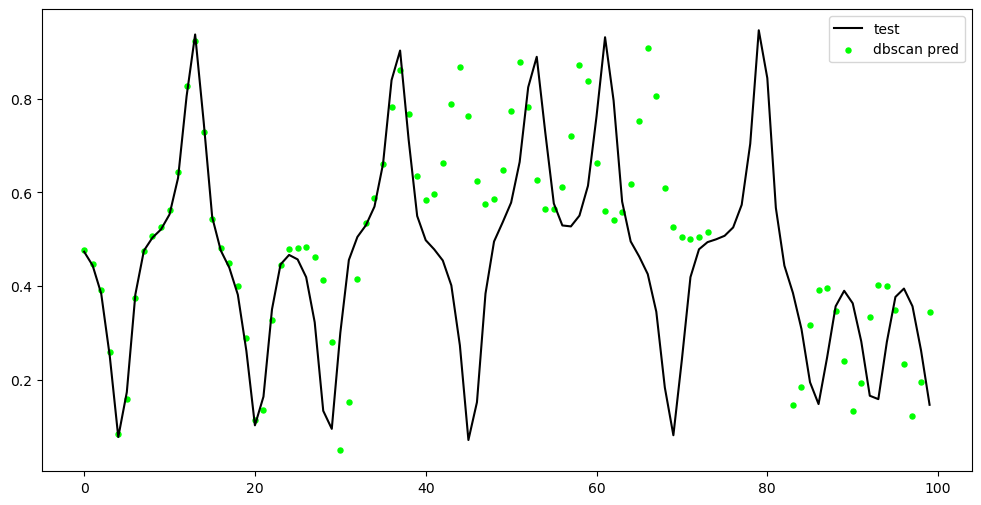

In [214]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(x_test[:100], c='black', label='test')
ax.scatter(np.arange(len(dbscan_predictions)), dbscan_predictions, c='lime', label='dbscan pred', s=13)

plt.legend()
plt.show()